<h1 align='center'>Sentiment Analysis of US Airline from Twiteer<h1>

The objective of this project is to analyze how travelers mentioned their feeling or review used US Airlines on Twitter in February 2015, and also we try to make model machine learning to classify Twitter sentiment from travelers. It would be helpful for airlines use this free data from Twitter to know how performance their service

The dataset can be downloaded from kaggle: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

Content overview:
1. Reading and Understanding data
2. Data Exploratory
3. Data preprocessing
4. Text analysis
5. Build model to predict airline sentiment
6. Final model
7. Single prediction

## 1. Reading and Understanding data

### Import library

In [1]:
import re
import sqlite3
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import emot as e
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk import ngrams, FreqDist
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV , GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report , roc_curve, auc

### Load dataset

In [2]:
conn = sqlite3.connect('./data/database.sqlite')
df = pd.read_sql_query('SELECT * FROM Tweets',conn).reset_index(drop=True)

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


As we can see there are many columns in the dataset, but we don't use all to analyze. The column with the name "airline_sentiment" will be a target variable and we can predict it based on traveler's tweets (column text).

### Drop columns that are not used

In [4]:
df1 = df.drop(columns=['tweet_id','airline_sentiment_confidence', 'negativereason_confidence','airline_sentiment_gold',
              'tweet_coord','tweet_created','tweet_location','user_timezone','negativereason_gold'])

### Checking missing value

In [5]:
df1.loc[df1.negativereason =='','negativereason'] = None

In [6]:
df1.isnull().sum()

airline_sentiment       0
negativereason       5403
airline                 0
name                    0
retweet_count           0
text                    0
dtype: int64

column "negativereason" have null values, because that column contains the reason of why "airline_sentiment" have negative sentiment, so we dont need to treat those null values

### Data overview

In [7]:
df1.head()

,airline_sentiment,negativereason,airline,name,retweet_count,text
0,neutral,None,Delta,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...
1,negative,Can't Tell,Delta,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
2,negative,Late Flight,United,CPoutloud,0,@united yes. We waited in line for almost an h...
3,negative,Late Flight,United,brenduch,0,@united the we got into the gate at IAH on tim...
4,negative,Customer Service Issue,Southwest,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...


In [8]:
df1.shape

(14485, 6)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14485 non-null  object
 1   negativereason     9082 non-null   object
 2   airline            14485 non-null  object
 3   name               14485 non-null  object
 4   retweet_count      14485 non-null  int64 
 5   text               14485 non-null  object
dtypes: int64(1), object(5)
memory usage: 679.1+ KB


In [10]:
df1.describe()

,retweet_count
count,14485.000000
mean,0.083397
std,0.749632
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,44.000000


In [11]:
df1.select_dtypes(include=object).describe()

,airline_sentiment,negativereason,airline,name,text
count,14485,9082,14485,14485,14485
unique,3,10,6,7701,14427
top,negative,Customer Service Issue,United,JetBlueNews,@united thanks
freq,9082,2885,3822,63,6


for analysis we would use 6 column and 14456 record data, lets visualize to get more insight!

## 2. Exploratory data

### Airline sentiment

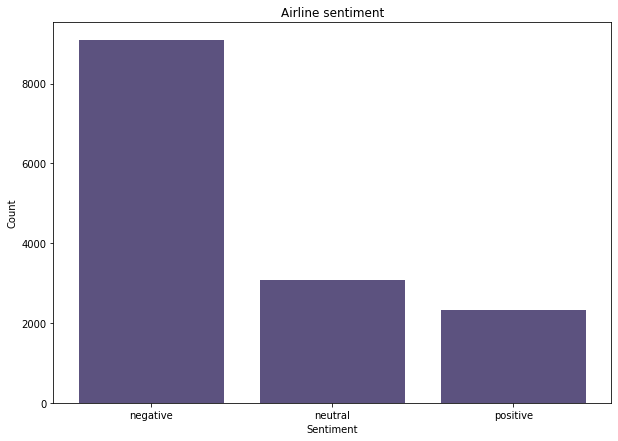

In [12]:
data = df1.groupby(['airline_sentiment']).size().reset_index(name='count')
plt.figure(figsize=(10,7))
plt.bar(data['airline_sentiment'],data['count'],color='#5C527F')
plt.title("Airline sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Majorities for airline sentiment are negative, between positive and negative have quite extreme value differences. but it would be great information for airline to improve serive better 

### Sentiment for each airline

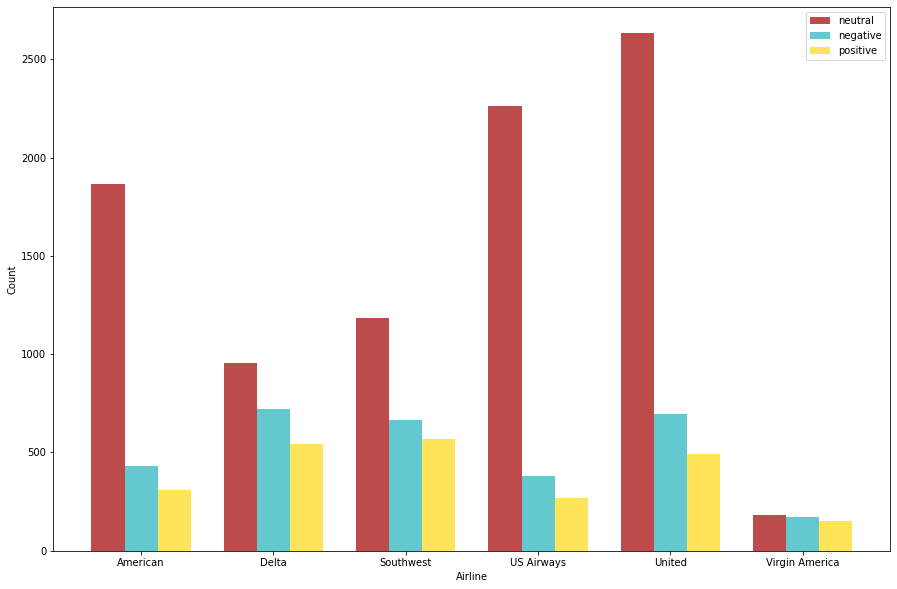

In [13]:
data = df1.groupby(['airline','airline_sentiment']).size().reset_index(name='count')
x = list(data['airline'].unique())
x_axis = np.arange(len(x))

plt.figure(figsize=(15,10))
plt.bar(x_axis - 0.25,data[data['airline_sentiment']=='negative'].iloc[:,-1],width=0.25,color='#BD4B4B',label='neutral')
plt.bar(x_axis,data[data['airline_sentiment']=='neutral'].iloc[:,-1],width=0.25,color = '#64C9CF',label='negative')
plt.bar(x_axis + 0.25,data[data['airline_sentiment']=='positive'].iloc[:,-1],width=0.25,color = '#FFE459',label='positive')

plt.xticks(x_axis,x)
plt.xlabel("Airline")
plt.ylabel("Count")
plt.legend()
plt.show()

Airlines with the most negative sentiment are United, US Airways, and American. Those airlines have a huge gap between negative  and positive sentiment

### The Reason of negative sentiment

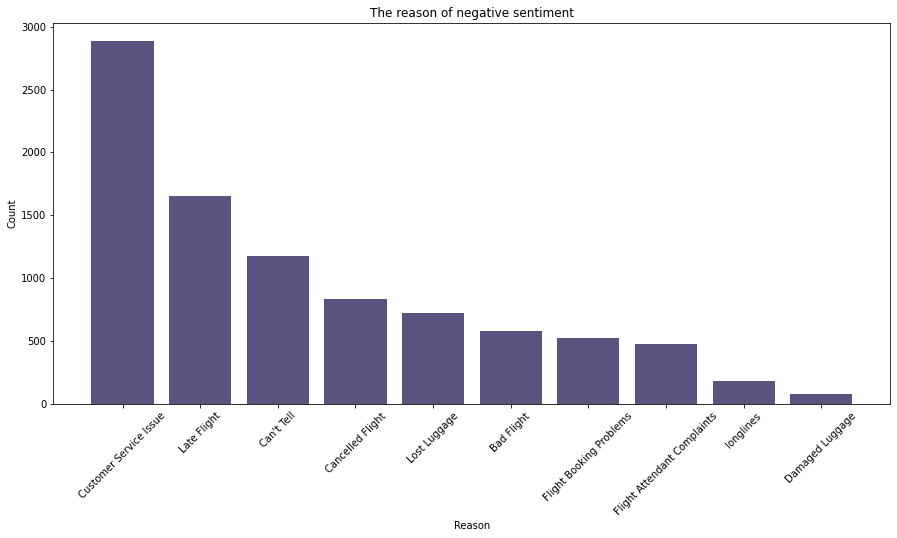

In [14]:
data = df1.groupby(['negativereason']).size().reset_index(name='count').sort_values('count',ascending=False)

plt.figure(figsize=(15,7))
plt.bar(data['negativereason'],data['count'],color='#5C527F')
plt.title("The reason of negative sentiment")
plt.xlabel("Reason")
plt.xticks(rotation = 45)
plt.ylabel("Count")
plt.show()

As you can see, majorities travelers give negative review are the customer service issue and flight delay. 

### Retweet of sentiment for each airline

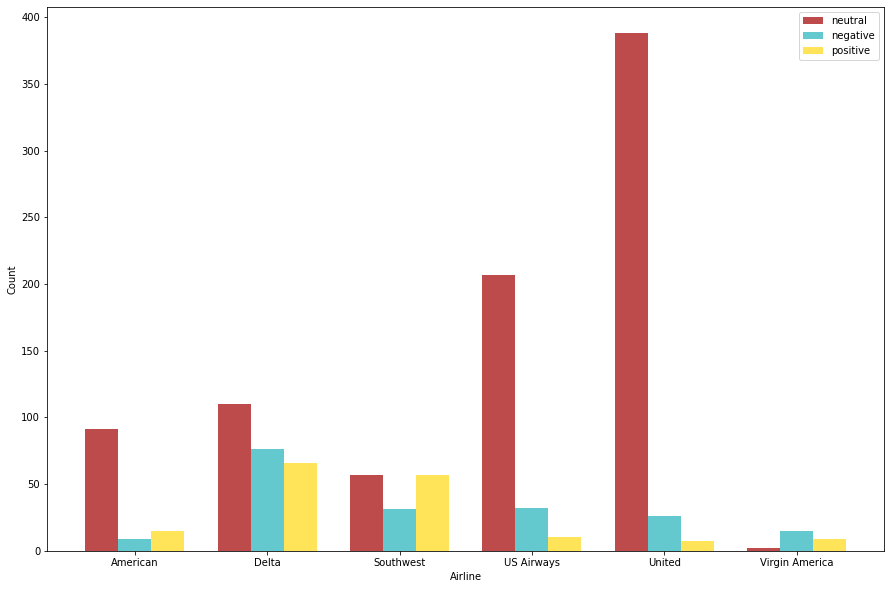

In [15]:
data = df1.groupby(['airline','airline_sentiment']).agg({'retweet_count':'sum'}).reset_index()
x = list(data['airline'].unique())
x_axis = np.arange(len(x))

plt.figure(figsize=(15,10))
plt.bar(x_axis - 0.25,data[data['airline_sentiment']=='negative'].iloc[:,-1],width=0.25,color='#BD4B4B',label='neutral')
plt.bar(x_axis,data[data['airline_sentiment']=='neutral'].iloc[:,-1],width=0.25,color = '#64C9CF',label='negative')
plt.bar(x_axis + 0.25,data[data['airline_sentiment']=='positive'].iloc[:,-1],width=0.25,color = '#FFE459',label='positive')

plt.xticks(x_axis,x)
plt.xlabel("Airline")
plt.ylabel("Count")
plt.legend()
plt.show()

The most populer airlines on twitter are United and US Airways. on sentiment for each airline, American airline including top 3 with the most negative sentiment, but American airline not so populer on twitter

## 3. Data Preprocessing

To predict tweets sentiment negative or positive, we need text from travelers that has been labeled. so we will select column text and airline sentiment and then drop neutral sentiment from label.

In [16]:
df1.head()

,airline_sentiment,negativereason,airline,name,retweet_count,text
0,neutral,None,Delta,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...
1,negative,Can't Tell,Delta,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
2,negative,Late Flight,United,CPoutloud,0,@united yes. We waited in line for almost an h...
3,negative,Late Flight,United,brenduch,0,@united the we got into the gate at IAH on tim...
4,negative,Customer Service Issue,Southwest,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...


### Select feature and target variable

In [17]:
data_prepro0 = df1[['text','airline_sentiment']]

### Drop neutral sentiment

In [18]:
data_prepro0 = data_prepro0[data_prepro0['airline_sentiment']!='neutral'] 

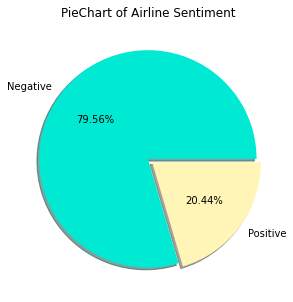

In [19]:
plt.figure(figsize=(5,5))
plt.title("PieChart of Airline Sentiment")
plt.pie(data_prepro0['airline_sentiment'].value_counts(),
       labels = ['Negative','Positive'],
       autopct ='%.2f%%',
       colors = ['#00EAD3','#FFF5B7'],
       explode=(0.0,0.05),
       shadow = True)
plt.show()

### Encoding target variable

Encoding target variabel negative or positive to 0 or 1 using get_dummies pandas

In [20]:
data_prepro1 = data_prepro0.reset_index(drop=True)
target = pd.get_dummies(data_prepro1['airline_sentiment'],drop_first=True)
data_prepro1['airline_sentiment'] = target

In [21]:
data_prepro1.head()

,text,airline_sentiment
0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,0
1,@united yes. We waited in line for almost an h...,0
2,@united the we got into the gate at IAH on tim...,0
3,@SouthwestAir its cool that my bags take a bit...,0
4,@united and don't hope for me having a nicer f...,0


### Text Preprocessing

this text preprocessing purpose to extract the most important of keywords or to derive high-quality information and actionable insights from text. 

1. convert emoji: to get mining of the emoji
2. cleaning text: to remove word remove meaningless words, (such as username, link website, hashtag and so on)
3. Tokenizing: convert text to be word by word
4. Remove stopwords : to remove a commonly used word (such as “the”, “a”, “an”, “in”)
5. Normalizing words : to change a word to its basic form
6. Untokenizing : to combine parts of words into a text.

In [22]:
token = WordPunctTokenizer()
stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(['us','hr','w'])
lemmatizer = WordNetLemmatizer()

#### Convert Emoji

In [23]:
def convert_emoji(texts):
    new_text = []
    for i,text in enumerate(texts):
        text0 = ''
        for emoji in e.UNICODE_EMOJI:
            if emoji in text:
                text = re.sub(r'[:]',"",
                                re.sub(r'[::]'," ",
                                    re.sub(r'['+emoji+']',e.UNICODE_EMOJI_ALIAS[emoji],text)))
        new_text.append(text)
    return new_text

#### Cleaning Text

In [24]:
def cleaning_text(texts):
    text_cleaned = []
    for text in texts:
        pattern1 = r'@[^ ]+'
        pattern2 = r'https?://[^ ]+'
        pattern3 = r'#[^ ]+'
        combined_pattern = r'|'.join((pattern1,pattern2,pattern3))
        www_patt = r'www.[^ ]+'
        text = re.sub(www_patt,'',re.sub(combined_pattern,'',text)).lower()
        text_cleaned.append(text)
    return text_cleaned

In [25]:
def cleaning_text2(texts):
    text_cleaned = []
    for text in texts:
        pattern4 = r'0-9[^ ]+'
        text = re.sub("[^a-zA-Z]"," ", re.sub(pattern4,'',text)).lower()
        text_cleaned.append(text)
    return text_cleaned

#### Tokenizing

In [26]:
def tokenizing(texts,token):
    word_tokenized = [token.tokenize(w) for w in texts]
    return word_tokenized

#### Removing stop words

In [27]:
def removing_stopwords(texts,stopwords):
    word_stopwords = []
    for text in texts:
        text = [w for w in text if w not in stopwords]
        word_stopwords.append(text)
    return word_stopwords

#### Normalizing words

In [28]:
def lemmatizing(texts,lemmatizer):
    word_lemmatized = []
    for text in texts:
        text = [lemmatizer.lemmatize(w) for w in text]
        word_lemmatized.append(text)
    return word_lemmatized

#### Untokenizing words

In [29]:
def untokenizing(texts):
    untokenized = []
    for text in texts:
        text0 = " ".join(w for w in text)
        untokenized.append(text0)
    return untokenized

In [30]:
def preprocessing_text(text,token,stopwords,lemmatizer):
    result = convert_emoji(text)
    result = cleaning_text(result)
    result = tokenizing(result,token)
    result = removing_stopwords(result,stopwords)
    result = lemmatizing(result,lemmatizer)
    result = untokenizing(result)
    result = cleaning_text2(result)
    return result

## 4. Words analysis

before we go to the classification stage, we will try to analyze the text of each sentiment (negative and positive) to get the majority of words in each sentiment using word count.

#### Words count

In [31]:
text_analysis = data_prepro1.copy()
text_analysis['text'] = preprocessing_text(data_prepro1['text'],token,stopwords,lemmatizer)

In [32]:
negative_sentiment = text_analysis[text_analysis['airline_sentiment']==0]
positive_sentiment = text_analysis[text_analysis['airline_sentiment']==1]

#### Negative words

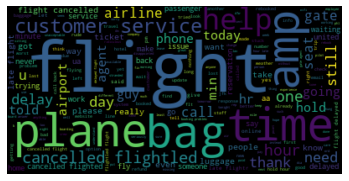

In [33]:
negative_review = " ".join(review for review in negative_sentiment['text'])
wordcloud = WordCloud().generate(negative_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [34]:
negative_tokenized = [token.tokenize(w) for w in negative_sentiment['text']]
negative_word = []
for text in negative_tokenized:
    negative_word += text

negative_wordcount = FreqDist(negative_word).most_common(20)

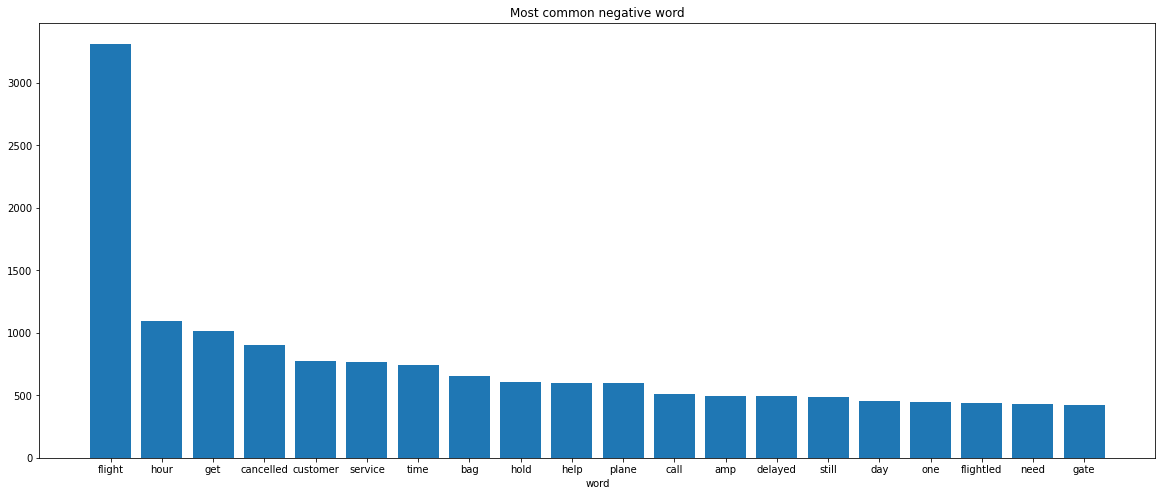

In [35]:
plt.figure(figsize=(20,8))
data = [list(w) for w in negative_wordcount]
x_axis = [v[0] for v in data]
y_axis = [v[1] for v in data]
plt.bar(x_axis,y_axis)
plt.title("Most common negative word")
plt.xlabel("word")
plt.show()

In negative sentiment, we see majorities of the word that indicates negative word like cencelled, delayed, hold, and so on.

#### Positive words

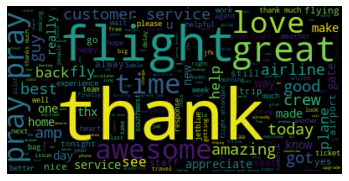

In [36]:
positive_review = " ".join(review for review in positive_sentiment['text'])
wordcloud = WordCloud().generate(positive_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [37]:
positive_tokenized = [token.tokenize(w) for w in positive_sentiment['text']]
positive_word = []
for text in positive_tokenized:
    positive_word += text

positive_wordcount = FreqDist(positive_word).most_common(20)

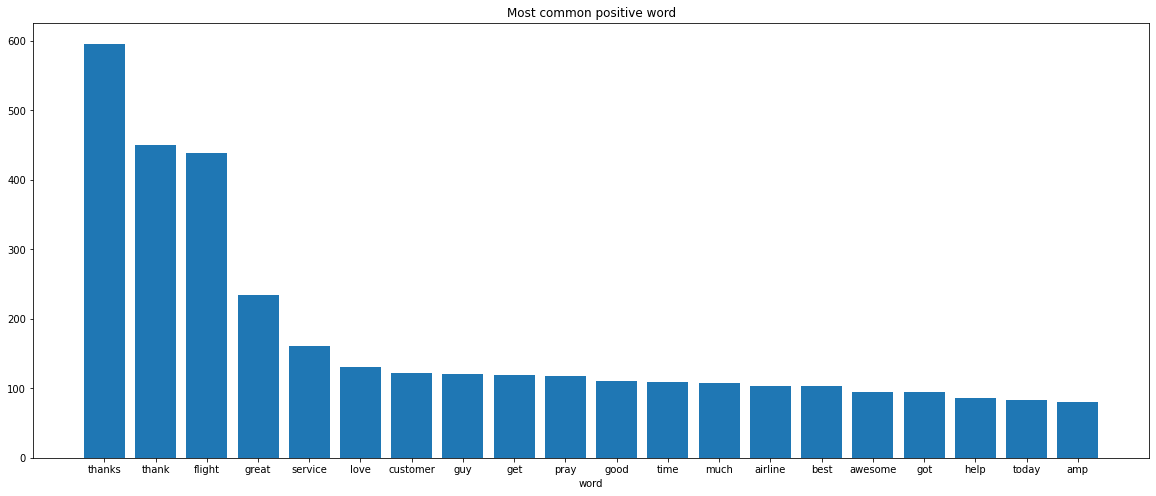

In [38]:
plt.figure(figsize=(20,8))
data = [list(w) for w in positive_wordcount]
x_axis = [v[0] for v in data]
y_axis = [v[1] for v in data]
plt.bar(x_axis,y_axis)
plt.title("Most common positive word")
plt.xlabel("word")
plt.show()

in postive sentiment, we found word that indicate positive feeling by travelers like thanks, great, love, pray, good, best, awesome, and so on.

At first glance, we see some words that are mostly in negative and positive sentiments, which are likely to affect the classification results, so we will remove these words from the text by adding them to the stopword corpus.

In [39]:
extend_stopwords = ['flight','customer','service','get','got','help','today','day','amp','time']

## 5. Build model to predict airline sentiment

There will be several phase before the data is ready to be trained:
1. Update stopwords
2. tf-idf vectorizing
3. Split dataset into train and testset

### Text processing

#### Update stopwords

In [40]:
stopwords.extend(extend_stopwords)

In [41]:
text_prepro = preprocessing_text(data_prepro1['text'],token,stopwords,lemmatizer)

#### TF-IDF Vectorizing text

tf-idf is one of term weighting or giving term weighting to the document. This weighting will be used by Machine Learning algorithm for document classification.

In [42]:
tfidf = TfidfVectorizer(max_features=5000).fit(text_prepro)
vectorized= tfidf.transform(text_prepro)

In [43]:
data_prepro =pd.DataFrame(vectorized.toarray(),columns=[tfidf.get_feature_names()])
data_prepro['airline_sentiment'] = data_prepro1['airline_sentiment']

### Split Dataset to train and test set

In [44]:
x = data_prepro.drop(columns=['airline_sentiment'])
y = data_prepro['airline_sentiment'].iloc[:,0].astype(int)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=1234,stratify=y)

### Default models

the data is ready to be trained, then we will build several models with default parameters:
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Machine
4. XGBoost
5. K-Nearest Neigbors Classifier

#### Logistic Regression

In [46]:
lr =  LogisticRegression(random_state=1234)
lr.fit(x_train,y_train)

LogisticRegression(random_state=1234)

In [47]:
lr_ypred = lr.predict(x_test)
print(classification_report(y_test, lr_ypred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1817
           1       0.89      0.57      0.69       467

    accuracy                           0.90      2284
   macro avg       0.89      0.77      0.81      2284
weighted avg       0.90      0.90      0.89      2284



In [48]:
lr_acc = accuracy_score(y_test, lr_ypred)
lr_f1 = f1_score(y_test, lr_ypred)
lr_prec = precision_score(y_test, lr_ypred)
lr_recall = recall_score(y_test, lr_ypred)
confusion_matrix(y_test, lr_ypred)

array([[1783,   34],
       [ 203,  264]], dtype=int64)

#### Random Forest Classifier

In [49]:
rf =  RandomForestClassifier(random_state=1234)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1234)

In [50]:
rf_ypred = rf.predict(x_test)
print(classification_report(y_test, rf_ypred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1817
           1       0.79      0.68      0.73       467

    accuracy                           0.90      2284
   macro avg       0.86      0.82      0.83      2284
weighted avg       0.89      0.90      0.89      2284



In [51]:
rf_acc = accuracy_score(y_test, rf_ypred)
rf_f1 = f1_score(y_test, rf_ypred)
rf_prec = precision_score(y_test, rf_ypred)
rf_recall = recall_score(y_test, rf_ypred)
confusion_matrix(y_test, rf_ypred)

array([[1735,   82],
       [ 151,  316]], dtype=int64)

#### Support Vector Machine

In [52]:
svm = SVC(random_state=1234,probability=True)
svm.fit(x_train, y_train)

SVC(probability=True, random_state=1234)

In [53]:
svm_ypred = svm.predict(x_test)
print(classification_report(y_test, svm_ypred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1817
           1       0.87      0.63      0.73       467

    accuracy                           0.91      2284
   macro avg       0.89      0.80      0.84      2284
weighted avg       0.90      0.91      0.90      2284



In [54]:
svm_acc = accuracy_score(y_test, svm_ypred)
svm_f1 = f1_score(y_test, svm_ypred)
svm_prec = precision_score(y_test, svm_ypred)
svm_recall = recall_score(y_test, svm_ypred)
confusion_matrix(y_test, svm_ypred)

array([[1774,   43],
       [ 173,  294]], dtype=int64)

#### XGBoost Classifier

In [55]:
xgb = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=1234)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1234, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [56]:
xgb_ypred = xgb.predict(x_test)
print(classification_report(y_test, xgb_ypred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1817
           1       0.82      0.63      0.71       467

    accuracy                           0.90      2284
   macro avg       0.87      0.80      0.82      2284
weighted avg       0.89      0.90      0.89      2284



In [57]:
xgb_acc = accuracy_score(y_test, xgb_ypred)
xgb_f1 = f1_score(y_test, xgb_ypred)
xgb_prec = precision_score(y_test, xgb_ypred)
xgb_recall = recall_score(y_test, xgb_ypred)
confusion_matrix(y_test, xgb_ypred)

array([[1755,   62],
       [ 175,  292]], dtype=int64)

#### K-Nearest Neigbors Classifier

In [58]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [59]:
knn_ypred = knn.predict(x_test)
print(classification_report(y_test, knn_ypred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1817
           1       0.54      0.29      0.38       467

    accuracy                           0.80      2284
   macro avg       0.69      0.61      0.63      2284
weighted avg       0.78      0.80      0.78      2284



In [60]:
knn_acc = accuracy_score(y_test, knn_ypred)
knn_f1 = f1_score(y_test, knn_ypred)
knn_prec = precision_score(y_test, knn_ypred)
knn_recall = recall_score(y_test, knn_ypred)
confusion_matrix(y_test, knn_ypred)

array([[1699,  118],
       [ 331,  136]], dtype=int64)

### Model comparation

In [61]:
result_dict = {'Model':['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'XGBoost', 'KNearest Neighbor'],
              'Accuracy':[lr_acc, rf_acc, svm_acc, xgb_acc, knn_acc],
              'F1':[lr_f1, rf_f1, svm_f1, xgb_f1, knn_f1],
              'Precision':[lr_prec, rf_prec, svm_prec, xgb_prec, knn_prec],
              'Recall':[lr_recall, rf_recall, svm_recall, xgb_recall, knn_recall]}
df_result = pd.DataFrame(result_dict)
df_result

,Model,Accuracy,F1,Precision,Recall
0,Logistic Regression,0.896235,0.690196,0.885906,0.565310
1,Random Forest,0.897986,0.730636,0.793970,0.676660
2,Support Vector Machine,0.905429,0.731343,0.872404,0.629550
3,XGBoost,0.896235,0.711328,0.824859,0.625268
4,KNearest Neighbor,0.803415,0.377254,0.535433,0.291221


there are several classification models that have been trained, one will be selected for hyperparameter tuning. we see that svm gets the best accuracy and f1 score, so we will try to do hyperparameter tuning on the svm model

### Hyperparameter tuning

in this section, we will find the best combination of parameters for the svm model using a randomized search cv

#### Randomized Search CV

In [62]:
svm_tune = SVC(random_state=1234)

In [63]:
svm_param ={'C':[1,2,5,6],
            'kernel':['rbf'],
            'gamma':[0.75, 0.5, 0.25, 1]}

In [64]:
svm_rand =  RandomizedSearchCV(svm_tune,
                        param_distributions=svm_param,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1,
                        random_state = 1234,
                        return_train_score=True)

In [ ]:
svm_fit = svm_rand.fit(x_train,y_train)

In [ ]:
svm_fit.best_params_

#### Training model with the best parameters

In [65]:
svm_final = SVC(C=5 , kernel='rbf' , gamma=0.5, probability=True  )
svm_final.fit(x_train,y_train)

SVC(C=5, gamma=0.5, probability=True)

In [66]:
svm_final_ypred = svm_final.predict(x_test)
print(classification_report(y_test, svm_final_ypred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1817
           1       0.83      0.73      0.78       467

    accuracy                           0.92      2284
   macro avg       0.88      0.85      0.86      2284
weighted avg       0.91      0.92      0.91      2284



In [67]:
svm_final_acc = accuracy_score(y_test, svm_final_ypred)
svm_final_f1 = f1_score(y_test, svm_final_ypred)
svm_final_prec = precision_score(y_test, svm_final_ypred)
svm_final_recall = recall_score(y_test, svm_final_ypred)

In [68]:
confusion_matrix(y_test, svm_final_ypred)

array([[1748,   69],
       [ 124,  343]], dtype=int64)

In [69]:
svm_final_yprob = svm_final.predict_proba(x_test)

In [70]:
fpr,tpr,threshold = roc_curve(y_test, svm_final_yprob[:,1])
roc_auc = auc(fpr,tpr)

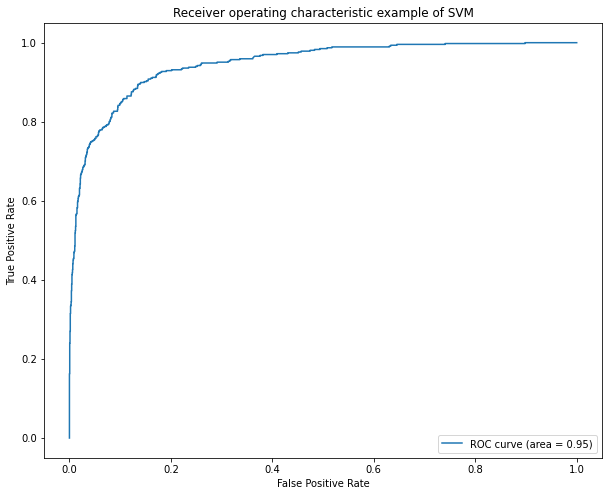

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example of SVM')
ax.legend(loc='lower right')
plt.show()

### Model comparation after hyperparamter tuning

In [72]:
final_df = pd.DataFrame([['Final SVM', svm_final_acc, svm_final_f1, svm_final_prec, svm_final_recall]],
               columns = ['Model','Accuracy','F1', 'Precision','Recall'])
final_result = df_result.append(final_df)
final_result

,Model,Accuracy,F1,Precision,Recall
0,Logistic Regression,0.896235,0.690196,0.885906,0.565310
1,Random Forest,0.897986,0.730636,0.793970,0.676660
2,Support Vector Machine,0.905429,0.731343,0.872404,0.629550
3,XGBoost,0.896235,0.711328,0.824859,0.625268
4,KNearest Neighbor,0.803415,0.377254,0.535433,0.291221
0,Final SVM,0.915499,0.780432,0.832524,0.734475


the result of final svm model has been increase, with accuracy is 91.5499% and f1-score is 78.0432%. The values of the variable target is not balanced, 79.56% : 20.44%. i thought the result of the final svm model is pretty good to predict sentiment class

## 6. Final Model

after we get the best model to predict sentiment class, we will use this model to predict new texts or tweets, so we need to save all attributes that are used to prediction, that attributes is:
- svm model
- tokenizer, stopwords, and lemmatizer
- tf-idf vectorizer
- function to text processing

#### Saving model

In [73]:
joblib.dump(svm_final,'svm_model.pkl')

['svm_model.pkl']

#### Saving tf-idf

In [74]:
joblib.dump(tfidf,'tfidf.pkl')

['tfidf.pkl']

#### Saving tokenizer, stopwords, lemmatizer

In [75]:
joblib.dump(token,'tokenizer.pkl')
joblib.dump(stopwords,'stopwords.pkl')
joblib.dump(lemmatizer,'lemmatizer.pkl')

['lemmatizer.pkl']

#### Function to text processing (text_processing.py)

to use this function you need to save it to be file .py. then if you will use it, just import this file to your project

In [ ]:
# Convert Emoji
def convert_emoji(text):
    new_text = ''
    for emoji in e.UNICODE_EMOJI:
        if emoji in text:
            text = re.sub(r'[:]',"",
                        re.sub(r'[::]'," ",
                               re.sub(r'['+emoji+']',e.UNICODE_EMOJI_ALIAS[emoji],text)))
    new_text = text
    
    return new_text

# Cleaning Text
def cleaning_text(text):
    pattern1 = r'@[^ ]+'
    pattern2 = r'https?://[^ ]+'
    pattern3 = r'#[^ ]+'
    combined_pattern = r'|'.join((pattern1,pattern2,pattern3))
    www_patt = r'www.[^ ]+'
    text_cleaned = re.sub(www_patt,'',re.sub(combined_pattern,'',text)).lower()

    return text_cleaned

def cleaning_text2(text):
    pattern4 = r'0-9[^ ]+'
    text_cleaned = re.sub("[^a-zA-Z]"," ", re.sub(pattern4,'',text)).lower()
    
    return text_cleaned

def text_processing(text,tokenizer,lemmatizer,stopwords):
    emoji_converted = convert_emoji(text)
    cleaned = cleaning_text(emoji_converted)
    # Tokenizing
    tokenized = tokenizer.tokenize(cleaned)
    # Remove stopwords
    word_stopwords = [w for w in tokenized if w not in stopwords]
    # Normalizing words
    word_lemmatized = [lemmatizer.lemmatize(w) for w in word_stopwords]
    # Untokenizing words
    untokenized = " ".join(w for w in word_lemmatized)
    text_processed = cleaning_text2(untokenized)
    
    return text_processed

## 7. Single prediction

we will try to predict a tweet using a trained model.

In [76]:
from text_processing import *

### Load model, tf-idf vectorizer, tokenizer, stopwords, lemmatizer

In [77]:
model = joblib.load('svm_model.pkl')
tfidf = joblib.load('tfidf.pkl')
token = joblib.load('tokenizer.pkl')
stopwords = joblib.load('stopwords.pkl')
lemmatizer = joblib.load('lemmatizer.pkl')

### Text 1

#### Input Text

In [78]:
text = "@american why is your airline always delayed?"

#### Text processing

In [79]:
text_pro0 = text_processing(text,token,lemmatizer,stopwords)
vectorized = tfidf.transform([text_pro0])
text_pro = vectorized.toarray().reshape(1,-1)

#### Prediction sentiment class

In [80]:
pred = model.predict(text_pro)

In [81]:
print(text)
print("")
if pred == 0:
    print("sentiment for this tweet is likely negative")
else:
    print("sentiment for this tweet is likely positive")

@american why is your airline always delayed?

sentiment for this tweet is likely negative


### Text 1

#### Input Text

In [82]:
text2 = "@fatihdq i like this airline, nice flight"

#### Text processing

In [83]:
text_pro0 = text_processing(text2,token,lemmatizer,stopwords)
vectorized = tfidf.transform([text_pro0])
text_pro = vectorized.toarray().reshape(1,-1)

#### Prediction sentiment class

In [84]:
pred = model.predict(text_pro)

In [85]:
print(text2)
print("")
if pred == 0:
    print("sentiment for this tweet is likely negative")
else:
    print("sentiment for this tweet is likely positive")

@fatihdq i like this airline, nice flight

sentiment for this tweet is likely positive
